In [1]:
from __future__ import division

import os; os.chdir(os.path.join('..', '..', '..'))
print os.getcwd()

/home/eharkin/projects/5HTGIF-dev


In [2]:
import warnings
import re

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import seaborn as sns
import numpy as np
from sklearn.model_selection import ParameterGrid

from grr.Simulation import GIFnet_Simulation
from grr.GainEstimator import GainEstimator
from grr.Tools import raiseExpectedGot, timeToIndex, reprint
from grr.Spiketrain import PSTH
from grr.CurveFit import plot_linear_fit

In [3]:
plt.style.use(os.path.join('figs', 'scripts', 'writeup', 'publication_figure_style.dms'))
plt.rc('text', usetex=False)
IMG_PATH = os.path.join('figs', 'ims', 'writeup', 'GIF_network')

In [4]:
DATA_PATH = os.path.join('data', 'simulations', 'GIF_network', 'step_input')

sim_dict = {'Circuit': [], 'Mod type': [], 'Condition': [], 'Rep': [], 'Model': []}

for network_model in ['DRN_base', 'DRN_noIA', 'DRN_fixedIA', 'DRN_truncatedAHP', 'DRN_truncatedAHP_noIA', 'mPFC_base']:
    for gaba_condition in os.listdir(os.path.join(DATA_PATH, network_model)):
        for fname in os.listdir(os.path.join(DATA_PATH, network_model, gaba_condition)):
            if fname.endswith(('hdf5', 'h5')):

                sim_dict['Circuit'].append(
                    re.search(r'(DRN|mPFC)_(.*)', network_model).groups()[-2]
                )
                sim_dict['Mod type'].append(
                    re.search(r'(DRN|mPFC)_(.*)', network_model).groups()[-1]
                )
                sim_dict['Condition'].append(
                    re.search(r'GABA_(.*)', gaba_condition).groups()[-1]
                )
                sim_dict['Rep'].append(
                    int(re.search(r'rep([0-9]+)', fname).groups()[-1])
                )
                sim_dict['Model'].append(
                    GIFnet_Simulation(
                        os.path.join(DATA_PATH, network_model, gaba_condition, fname), 
                        mode = 'r'
                    )
                )

sim_df = pd.DataFrame(sim_dict).sort_values(['Mod type', 'Condition', 'Rep'])
sim_df.reset_index(inplace=True, drop=True)
sim_df.head()

,Circuit,Condition,Mod type,Model,Rep
0,DRN,KO,base,[ser],0
1,mPFC,KO,base,[ser],0
2,DRN,KO,base,[ser],1
3,mPFC,KO,base,[ser],1
4,DRN,KO,base,[ser],2


In [5]:
sim_df['Principal PSTH'] = None
sim_df['Principal PSTH'] = sim_df['Principal PSTH'].astype(object)
sim_df['GABA PSTH'] = None
sim_df['GABA PSTH'] = sim_df['GABA PSTH'].astype(object)

In [6]:
PSTH_width = 50.

for i in range(sim_df.shape[0]):
    reprint('Computing PSTH {:.1f}%'.format(100. * i / sim_df.shape[0]))
    
    # Get PSTH from 5HT population.
    sim_df.at[i, 'Principal PSTH'] = np.empty((
        sim_df.loc[i, 'Model'].get_no_sweeps(), 
        sim_df.loc[i, 'Model'].get_no_timesteps()
    ))
    for sweep_no in range(sim_df.loc[i, 'Model'].get_no_sweeps()):
        sim_df.loc[i, 'Principal PSTH'][sweep_no, :] = PSTH(
            sim_df.loc[i, 'Model'].ser_spktrains[sweep_no, ...].sum(axis = 0),
            PSTH_width,
            sim_df.loc[i, 'Model'].get_no_ser_neurons()
        )
    
    # Get PSTHs from GABA population.
    if sim_df.loc[i, 'Condition'] != 'KO':
        sim_df.at[i, 'GABA PSTH'] = np.empty((
            sim_df.loc[i, 'Model'].get_no_sweeps(), 
            sim_df.loc[i, 'Model'].get_no_timesteps()
        ))
        for sweep_no in range(sim_df.loc[i, 'Model'].get_no_sweeps()):
            sim_df.loc[i, 'GABA PSTH'][sweep_no, :] = PSTH(
                sim_df.loc[i, 'Model'].gaba_spktrains[sweep_no, ...].sum(axis = 0),
                PSTH_width,
                sim_df.loc[i, 'Model'].get_no_gaba_neurons()
            )
    else:
        sim_df.loc[i, 'GABA PSTH'] = None
        continue

print('\nDone!')

Computing PSTH 99.4%
Done!


In [7]:
psth_dict = {'Circuit': [], 'Mod type': [], 'Condition': [], 'Principal PSTH': [], 'GABA PSTH': []}
for circuit in sim_df['Circuit'].unique():
    for modtype in sim_df.loc[sim_df['Circuit'] == circuit, 'Mod type'].unique():
        for cond in sim_df.loc[(sim_df['Circuit'] == circuit) & (sim_df['Mod type'] == modtype), 'Condition'].unique():
            psth_dict['Circuit'].append(circuit)
            psth_dict['Mod type'].append(modtype)
            psth_dict['Condition'].append(cond)
            psth_dict['Principal PSTH'].append(np.array(
                sim_df.loc[(sim_df['Circuit'] == circuit) & (sim_df['Condition'] == cond) & (sim_df['Mod type'] == modtype), 'Principal PSTH'].tolist()
            ))
            psth_dict['GABA PSTH'].append(np.array(
                sim_df.loc[(sim_df['Circuit'] == circuit) & (sim_df['Condition'] == cond) & (sim_df['Mod type'] == modtype), 'GABA PSTH'].tolist()
            ))
psth_df = pd.DataFrame(psth_dict)
del psth_dict

In [8]:
psth_df.head()

,Circuit,Condition,GABA PSTH,Mod type,Principal PSTH
0,DRN,KO,"[None, None, None, None, None, None, None, Non...",base,"[[[0.26666666666666666, 0.26666666666666666, 0..."
1,DRN,base,"[[[2.2, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2....",base,"[[[0.26666666666666666, 0.26666666666666666, 0..."
2,DRN,noinput,"[[[1.7000000000000002, 1.7000000000000002, 1.7...",base,"[[[0.3666666666666667, 0.3666666666666667, 0.3..."
3,DRN,KO,"[None, None, None, None, None, None, None, Non...",fixedIA,"[[[0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3..."
4,DRN,base,"[[[2.2, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2....",fixedIA,"[[[0.23333333333333334, 0.23333333333333334, 0..."


In [9]:
def select_PSTH_dataset(dframe, circuit, condition, mod_type, psth_type='Principal PSTH'):
    return dframe.loc[
        (dframe['Circuit'] == circuit)
        & (dframe['Condition'] == condition) 
        & (dframe['Mod type'] == mod_type), 
        psth_type
    ].item()

In [10]:
def get_step_amplitudes(simulation, step_start_time):
    step_start_ind = timeToIndex(step_start_time, 0.1)[0]
    baseline = simulation['ser/examples/I'][..., :step_start_ind].mean()
    return simulation['ser/examples/I'][..., step_start_ind:].mean(axis=2).mean(axis=1) - baseline

def get_pointwise_gain(psth_arr, step_amplitudes, baseline_start_time, step_start_time, cov=False, dt=0.1):
    """
    Returns
    -------
    (gain, intercept) if cov = False, or (gain, intercept, parameter_covariance_matrix) if cov=True.
    
    """
    assert np.ndim(psth_arr) == 3
    assert np.ndim(step_amplitudes) == 1
    assert np.shape(psth_arr)[1] == len(step_amplitudes)
    
    step_start_ind = timeToIndex(step_start_time, dt)[0]
    step_response = psth_arr[..., step_start_ind:]
    mean_step_response = step_response.mean(axis=0)
    
    baseline_activity = psth_arr[..., timeToIndex(baseline_start_time, dt)[0]:step_start_ind]
    mean_baseline_activity = baseline_activity.mean(axis=0).mean(axis=1)  # Average over sweeps and time.
    assert np.ndim(mean_baseline_activity) == 1
    assert len(mean_baseline_activity) == mean_step_response.shape[0]
    
    coeffs, V = np.polyfit(step_amplitudes, mean_step_response - mean_baseline_activity[:, np.newaxis], deg=1, cov=cov)
    
    if cov:
        return coeffs[0, :], coeffs[1, :], V
    else:
        return coeffs[0, :], coeffs[1, :]

In [11]:
step_amplitudes = get_step_amplitudes(sim_df.loc[0, 'Model'], 1000.)

In [12]:
def plot_lines_cmap(x, y, cmap, start=0., stop=1., ax=None, **pltargs):
    if ax is None:
        ax = plt.gca()
    
    colors = cmap(np.linspace(start, stop, np.shape(y)[1]))
    for i in range(np.shape(y)[1]):
        ax.plot(x, y[:, i], color=colors[i], **pltargs)

In [13]:
class GainSimulationVisualizer(object):
    def __init__(
        self,
        psth_dataframe,
        step_amplitudes,
        baseline_interval,
        stimulus_interval,
        dt=0.1,
    ):
        """Initialize GainSimulationVisualizer.

        Arguments
        ---------
        psth_dataframe : pandas.DataFrame
        step_amplitudes : 1D float array
        baseline_interval, stimulus_interval : pair of floats
            Time window to extract baseline/stimulus (ms).
        dt : float, default 0.1
            Time step (ms).

        """
        self.psth_dataframe = psth_dataframe
        self.step_amplitudes = step_amplitudes
        self.baseline_interval = baseline_interval
        self.stimulus_interval = stimulus_interval
        self.dt = dt

    def plot_gain(
        self, circuit, condition, mod_type, psth_type, ax=None, label=None, **pltargs
    ):
        """Plot gain over time.

        Wraps select_PSTH_dataset.

        """
        if ax is None:
            ax = plt.gca()

        gain_estimator = self._fit_gain_estimator(
            circuit, condition, mod_type, psth_type
        )

        ax.fill_between(
            self._get_time_support(),
            gain_estimator.gain - gain_estimator.gainUncertainty,
            gain_estimator.gain + gain_estimator.gainUncertainty,
            alpha=0.7,
            lw=0,
            **pltargs
        )
        ax.plot(self._get_time_support(), gain_estimator.gain, label=label, **pltargs)

    def plot_intercept(
        self, circuit, condition, mod_type, psth_type, ax=None, label=None, **pltargs
    ):
        """Plot intercept over time.

        Wraps select_PSTH_dataset.

        """
        if ax is None:
            ax = plt.gca()

        gain_estimator = self._fit_gain_estimator(
            circuit, condition, mod_type, psth_type
        )

        ax.fill_between(
            self._get_time_support(),
            gain_estimator.intercept - gain_estimator.interceptUncertainty,
            gain_estimator.intercept + gain_estimator.interceptUncertainty,
            alpha=0.7,
            lw=0,
            **pltargs
        )
        ax.plot(self._get_time_support(), gain_estimator.intercept, label=label, **pltargs)

    def _fit_gain_estimator(self, circuit, condition, mod_type, psth_type):
        dset = select_PSTH_dataset(
            self.psth_dataframe, circuit, condition, mod_type, psth_type
        )
        gain_estimator = GainEstimator(self.dt)
        gain_estimator.fit(
            dset,
            self.step_amplitudes,
            self.baseline_interval,
            self.stimulus_interval,
        )
        return gain_estimator
    
    def plot_psth(self, circuit, condition, mod_type, psth_type, sweeps, cmap, ax=None, label=None, **pltargs):
        dset = select_PSTH_dataset(
            self.psth_dataframe, circuit, condition, mod_type, psth_type
        )
        psth_mean = dset[..., self._get_stimulus_slice()].mean(axis=0)
        psth_std = dset[..., self._get_stimulus_slice()].std(axis=0)
        
        if ax is None:
            ax = plt.gca()
        
        colors = cmap(np.linspace(0.3, 1., psth_mean.shape[0]))
        labeled_flag = False
        for i in sweeps:
            ax.fill_between(
                self._get_time_support(), 
                psth_mean[i, :] - psth_std[i, :], 
                psth_mean[i, :] + psth_std[i, :], 
                color=colors[i], 
                alpha=0.7,
                lw=0,
                **pltargs
            )
            if not labeled_flag:
                ax.plot(self._get_time_support(), psth_mean[i, :], color=colors[i], label=label, **pltargs)
                labeled_flag = True
            else:
                ax.plot(self._get_time_support(), psth_mean[i, :], color=colors[i], **pltargs)
    
    def _get_stimulus_slice(self):
        return slice(*timeToIndex(self.stimulus_interval, self.dt))

    def _get_time_support(self):
        return np.arange(
            0.0,
            (self.stimulus_interval[1] - self.stimulus_interval[0])
            - 0.5 * self.dt,
            self.dt,
        )

In [14]:
visualizer = GainSimulationVisualizer(psth_df, step_amplitudes, (800., 900.), (1000., 1900.))

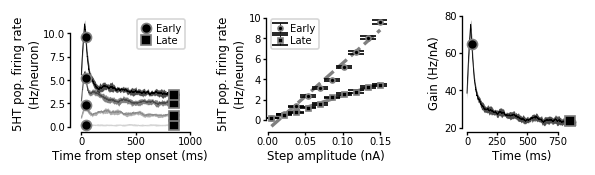

In [19]:
ser_ctrl_psth = select_PSTH_dataset(psth_df, 'DRN', 'base', 'base', 'Principal PSTH')

ebar_params = {'ls': 'none', 'capsize': 5, 'ecolor': 'k', 'markersize': 3}
markeredgecolor='gray'
cmap = plt.get_cmap('Greys')
stim_start_time = 1000.
peak_ind = 10400
steady_ind = 18500
t_vec = sim_df['Model'][0].get_t_vec() - stim_start_time

spec = gs.GridSpec(1, 3)

plt.figure(figsize=(5, 1.5))

plt.subplot(spec[:, 0])
visualizer.plot_psth('DRN', 'base', 'base', 'Principal PSTH', range(0, 10, 3), cmap)
#plot_lines_cmap(t_vec, ser_ctrl_psth[0, ::3, :].T, cmap, start=0.1)
plt.plot(
    [peak_ind * 0.1 - stim_start_time] * 4, 
    ser_ctrl_psth[:, ::3, peak_ind].mean(axis=0), 
    'ko', label='Early', markeredgecolor=markeredgecolor
)
plt.plot(
    [steady_ind * 0.1 - stim_start_time] * 4, 
    ser_ctrl_psth[:, ::3, steady_ind].mean(axis=0), 
    'ks', label='Late', markeredgecolor=markeredgecolor
)
plt.xlim(-100., 1000.)
plt.xlabel('Time from step onset (ms)')
plt.ylabel('5HT pop. firing rate\n(Hz/neuron)')
plt.legend()

plt.subplot(spec[:, 1])
plt.errorbar(
    marker='o',
    color='k',
    markeredgecolor=markeredgecolor,
    x=step_amplitudes,
    y=ser_ctrl_psth[..., peak_ind].mean(axis=0), 
    yerr=ser_ctrl_psth[..., peak_ind].std(axis=0)/np.sqrt(ser_ctrl_psth.shape[0]),
    label='Early',
    **ebar_params
)
plt.errorbar(
    marker='s',
    color='k',
    markeredgecolor=markeredgecolor,
    x=step_amplitudes,
    y=ser_ctrl_psth[..., steady_ind].mean(axis=0), 
    yerr=ser_ctrl_psth[..., steady_ind].std(axis=0)/np.sqrt(ser_ctrl_psth.shape[0]),
    label='Late',
    **ebar_params
)
plot_linear_fit(step_amplitudes, ser_ctrl_psth[..., peak_ind].mean(axis=0), zorder=-1, lw=2, ls='--', color='gray')
plot_linear_fit(step_amplitudes, ser_ctrl_psth[..., steady_ind].mean(axis=0), zorder=-1, lw=2, ls='--', color='gray')
plt.ylabel('5HT pop. firing rate\n(Hz/neuron)')
plt.xlabel('Step amplitude (nA)')
plt.legend()

plt.subplot(spec[:, 2])
visualizer.plot_gain('DRN', 'base', 'base', 'Principal PSTH', color='k')

ser_gain = GainEstimator(0.1)
ser_gain.fit(select_PSTH_dataset(psth_df, 'DRN', 'base', 'base', 'Principal PSTH'), step_amplitudes, (800., 900.), (1000., 1900.))

plt.plot(
    [peak_ind * 0.1 - stim_start_time], 
    [ser_gain.gain[peak_ind - timeToIndex(stim_start_time, 0.1)[0]] ],
    'ko',
    markeredgecolor=markeredgecolor
)
plt.plot(
    [steady_ind * 0.1 - stim_start_time], 
    [ser_gain.gain[steady_ind - timeToIndex(stim_start_time, 0.1)[0]]],
    'ks',
    markeredgecolor=markeredgecolor
)
plt.ylabel('Gain (Hz/nA)')
plt.xlabel('Time (ms)')

sns.despine(trim=True)

plt.tight_layout()

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'control_gain_illustration.png'))

del ser_ctrl_psth, ser_gain

# Effect of IA in network without GABA

Step amplitudes [0.05338645 0.1178309 ] (nA) are shown.


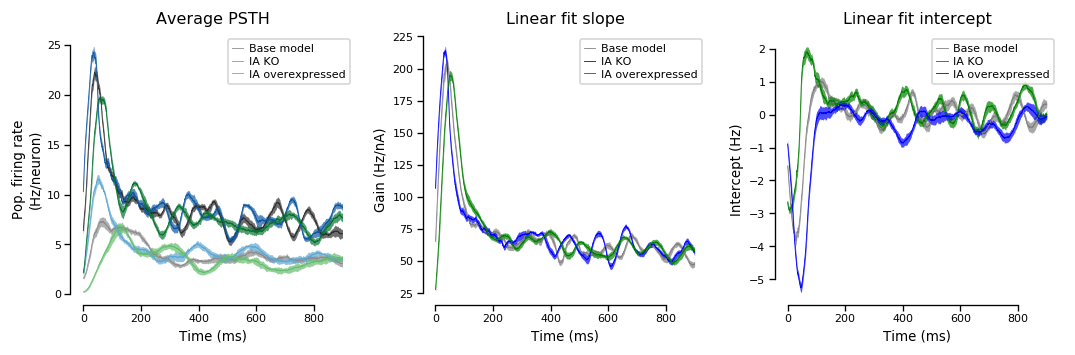

In [16]:
sweeps = [3, 7]

plt.figure(figsize=(9, 3))

plt.subplot(131)
plt.title('Average PSTH')
visualizer.plot_psth('DRN', 'KO', 'base', 'Principal PSTH', sweeps, label='Base model', cmap=plt.get_cmap('Greys'))
visualizer.plot_psth('DRN', 'KO', 'noIA', 'Principal PSTH', sweeps, label='IA KO', cmap=plt.get_cmap('Blues'))
visualizer.plot_psth('DRN', 'KO', 'fixedIA', 'Principal PSTH', sweeps, label='IA overexpressed', cmap=plt.get_cmap('Greens'))
plt.xlabel('Time (ms)')
plt.ylabel('Pop. firing rate\n(Hz/neuron)')
plt.legend()

plt.subplot(132)
plt.title('Linear fit slope')
visualizer.plot_gain('DRN', 'KO', 'base', 'Principal PSTH', color='gray', label='Base model')
visualizer.plot_gain('DRN', 'KO', 'noIA', 'Principal PSTH', color='blue', label='IA KO')
visualizer.plot_gain('DRN', 'KO', 'fixedIA', 'Principal PSTH', color='green', label='IA overexpressed')
plt.xlabel('Time (ms)')
plt.ylabel('Gain (Hz/nA)')
plt.legend()

plt.subplot(133)
plt.title('Linear fit intercept')
visualizer.plot_intercept('DRN', 'KO', 'base', 'Principal PSTH', color='gray', label='Base model')
visualizer.plot_intercept('DRN', 'KO', 'noIA', 'Principal PSTH', color='green', label='IA KO')
visualizer.plot_intercept('DRN', 'KO', 'fixedIA', 'Principal PSTH', color='blue', label='IA overexpressed')
plt.xlabel('Time (ms)')
plt.ylabel('Intercept (Hz)')
plt.legend()

sns.despine(trim=True)
plt.tight_layout()

print('Step amplitudes {} (nA) are shown.'.format(step_amplitudes[sweeps]))

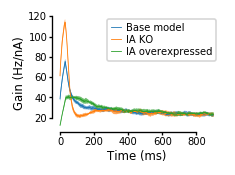

In [23]:
plt.figure(figsize=(2, 1.5))

plt.subplot(111)
visualizer.plot_gain('DRN', 'base', 'base', 'Principal PSTH', label='Base model')
visualizer.plot_gain('DRN', 'base', 'noIA', 'Principal PSTH', label='IA KO')
visualizer.plot_gain('DRN', 'base', 'fixedIA', 'Principal PSTH', label='IA overexpressed')
plt.xlabel('Time (ms)')
plt.ylabel('Gain (Hz/nA)')
plt.legend()

sns.despine(trim=True)
plt.tight_layout()

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'IA_gain_illustration.png'))

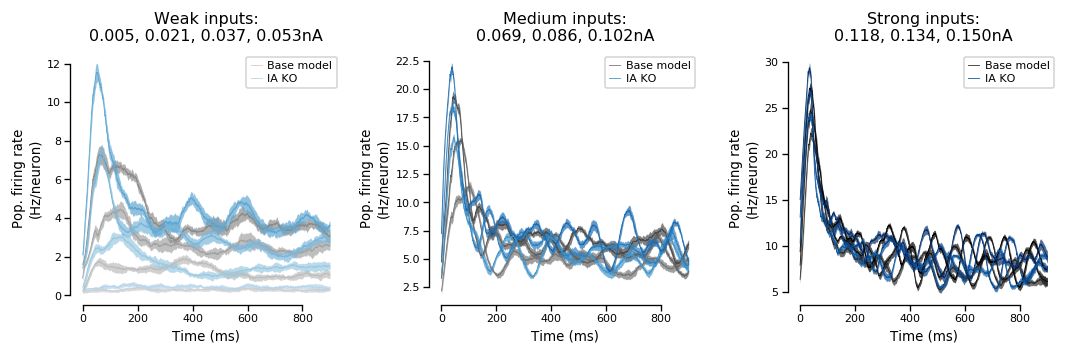

In [18]:
low_input_range = [0, 1, 2, 3]
med_input_range = [4, 5, 6]
high_input_range = [7, 8, 9]

plt.figure(figsize=(9, 3))

plt.subplot(131)
plt.title('Weak inputs:\n{}nA'.format(', '.join(['{:.3f}'.format(x) for x in step_amplitudes[low_input_range]])))
visualizer.plot_psth('DRN', 'KO', 'base', 'Principal PSTH', low_input_range, label='Base model', cmap=plt.get_cmap('Greys'))
visualizer.plot_psth('DRN', 'KO', 'noIA', 'Principal PSTH', low_input_range, label='IA KO', cmap=plt.get_cmap('Blues'))
#visualizer.plot_psth('DRN', 'KO', 'fixedIA', 'Principal PSTH', low_input_range, label='IA overexpressed', cmap=plt.get_cmap('Greens'))
plt.xlabel('Time (ms)')
plt.ylabel('Pop. firing rate\n(Hz/neuron)')
plt.legend()

plt.subplot(132)
plt.title('Medium inputs:\n{}nA'.format(', '.join(['{:.3f}'.format(x) for x in step_amplitudes[med_input_range]])))
visualizer.plot_psth('DRN', 'KO', 'base', 'Principal PSTH', med_input_range, label='Base model', cmap=plt.get_cmap('Greys'))
visualizer.plot_psth('DRN', 'KO', 'noIA', 'Principal PSTH', med_input_range, label='IA KO', cmap=plt.get_cmap('Blues'))
#visualizer.plot_psth('DRN', 'KO', 'fixedIA', 'Principal PSTH', med_input_range, label='IA overexpressed', cmap=plt.get_cmap('Greens'))
plt.xlabel('Time (ms)')
plt.ylabel('Pop. firing rate\n(Hz/neuron)')
plt.legend()

plt.subplot(133)
plt.title('Strong inputs:\n{}nA'.format(', '.join(['{:.3f}'.format(x) for x in step_amplitudes[high_input_range]])))
visualizer.plot_psth('DRN', 'KO', 'base', 'Principal PSTH', high_input_range, label='Base model', cmap=plt.get_cmap('Greys'))
visualizer.plot_psth('DRN', 'KO', 'noIA', 'Principal PSTH', high_input_range, label='IA KO', cmap=plt.get_cmap('Blues'))
#visualizer.plot_psth('DRN', 'KO', 'fixedIA', 'Principal PSTH', high_input_range, label='IA overexpressed', cmap=plt.get_cmap('Greens'))
plt.xlabel('Time (ms)')
plt.ylabel('Pop. firing rate\n(Hz/neuron)')
plt.legend()

sns.despine(trim=True)
plt.tight_layout()
plt.show()

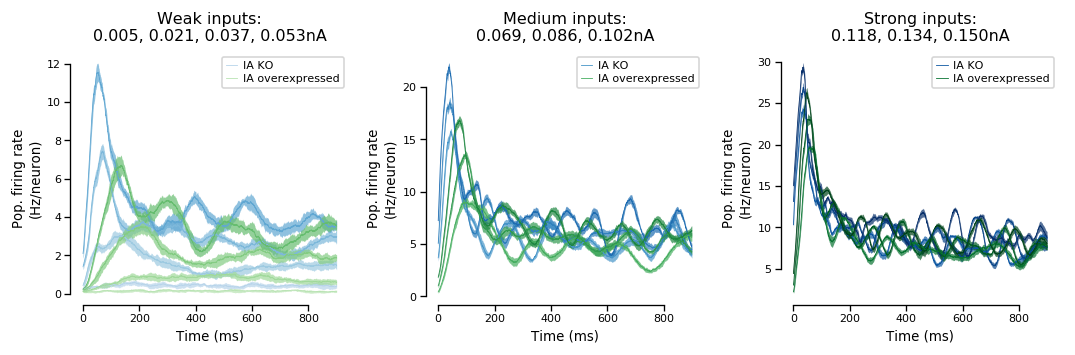

In [19]:
low_input_range = [0, 1, 2, 3]
med_input_range = [4, 5, 6]
high_input_range = [7, 8, 9]

plt.figure(figsize=(9, 3))

plt.subplot(131)
plt.title('Weak inputs:\n{}nA'.format(', '.join(['{:.3f}'.format(x) for x in step_amplitudes[low_input_range]])))
#visualizer.plot_psth('DRN', 'KO', 'base', 'Principal PSTH', low_input_range, label='Base model', cmap=plt.get_cmap('Greys'))
visualizer.plot_psth('DRN', 'KO', 'noIA', 'Principal PSTH', low_input_range, label='IA KO', cmap=plt.get_cmap('Blues'))
visualizer.plot_psth('DRN', 'KO', 'fixedIA', 'Principal PSTH', low_input_range, label='IA overexpressed', cmap=plt.get_cmap('Greens'))
plt.xlabel('Time (ms)')
plt.ylabel('Pop. firing rate\n(Hz/neuron)')
plt.legend()

plt.subplot(132)
plt.title('Medium inputs:\n{}nA'.format(', '.join(['{:.3f}'.format(x) for x in step_amplitudes[med_input_range]])))
#visualizer.plot_psth('DRN', 'KO', 'base', 'Principal PSTH', med_input_range, label='Base model', cmap=plt.get_cmap('Greys'))
visualizer.plot_psth('DRN', 'KO', 'noIA', 'Principal PSTH', med_input_range, label='IA KO', cmap=plt.get_cmap('Blues'))
visualizer.plot_psth('DRN', 'KO', 'fixedIA', 'Principal PSTH', med_input_range, label='IA overexpressed', cmap=plt.get_cmap('Greens'))
plt.xlabel('Time (ms)')
plt.ylabel('Pop. firing rate\n(Hz/neuron)')
plt.legend()

plt.subplot(133)
plt.title('Strong inputs:\n{}nA'.format(', '.join(['{:.3f}'.format(x) for x in step_amplitudes[high_input_range]])))
#visualizer.plot_psth('DRN', 'KO', 'base', 'Principal PSTH', high_input_range, label='Base model', cmap=plt.get_cmap('Greys'))
visualizer.plot_psth('DRN', 'KO', 'noIA', 'Principal PSTH', high_input_range, label='IA KO', cmap=plt.get_cmap('Blues'))
visualizer.plot_psth('DRN', 'KO', 'fixedIA', 'Principal PSTH', high_input_range, label='IA overexpressed', cmap=plt.get_cmap('Greens'))
plt.xlabel('Time (ms)')
plt.ylabel('Pop. firing rate\n(Hz/neuron)')
plt.legend()

sns.despine(trim=True)
plt.tight_layout()
plt.show()

# Effect of GABA in network with IA

Step amplitudes [0.05338645 0.1178309 ] (nA) are shown.


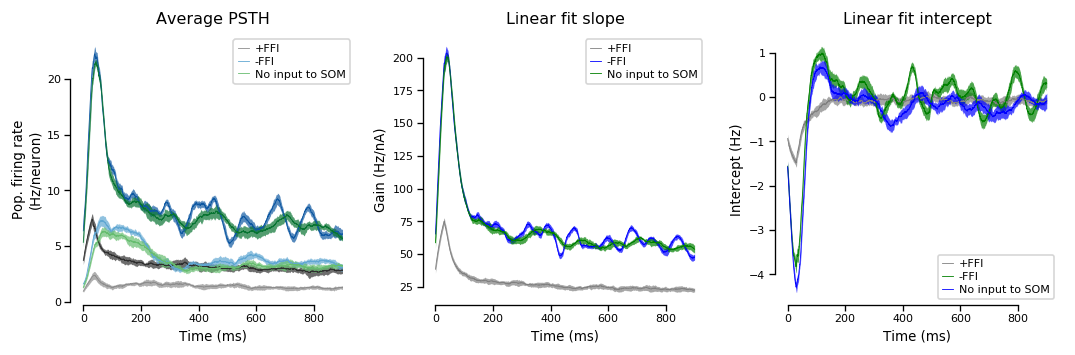

In [20]:
sweeps = [3, 7]

plt.figure(figsize=(9, 3))

plt.subplot(131)
plt.title('Average PSTH')
visualizer.plot_psth('DRN', 'base', 'base', 'Principal PSTH', sweeps, label='+FFI', cmap=plt.get_cmap('Greys'))
visualizer.plot_psth('DRN', 'KO', 'base', 'Principal PSTH', sweeps, label='-FFI', cmap=plt.get_cmap('Blues'))
visualizer.plot_psth('DRN', 'noinput', 'base', 'Principal PSTH', sweeps, label='No input to SOM', cmap=plt.get_cmap('Greens'))
plt.xlabel('Time (ms)')
plt.ylabel('Pop. firing rate\n(Hz/neuron)')
plt.legend()

plt.subplot(132)
plt.title('Linear fit slope')
visualizer.plot_gain('DRN', 'base', 'base', 'Principal PSTH', color='gray', label='+FFI')
visualizer.plot_gain('DRN', 'KO', 'base', 'Principal PSTH', color='blue', label='-FFI')
visualizer.plot_gain('DRN', 'noinput', 'base', 'Principal PSTH', color='green', label='No input to SOM')
plt.xlabel('Time (ms)')
plt.ylabel('Gain (Hz/nA)')
plt.legend()

plt.subplot(133)
plt.title('Linear fit intercept')
visualizer.plot_intercept('DRN', 'base', 'base', 'Principal PSTH', color='gray', label='+FFI')
visualizer.plot_intercept('DRN', 'KO', 'base', 'Principal PSTH', color='green', label='-FFI')
visualizer.plot_intercept('DRN', 'noinput', 'base', 'Principal PSTH', color='blue', label='No input to SOM')
plt.xlabel('Time (ms)')
plt.ylabel('Intercept (Hz)')
plt.legend()

sns.despine(trim=True)
plt.tight_layout()

print('Step amplitudes {} (nA) are shown.'.format(step_amplitudes[sweeps]))

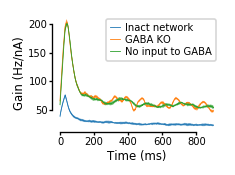

In [21]:
plt.figure(figsize=(2, 1.5))

plt.subplot(111)
visualizer.plot_gain('DRN', 'base', 'base', 'Principal PSTH', label='Inact network')
visualizer.plot_gain('DRN', 'KO', 'base', 'Principal PSTH', label='GABA KO')
visualizer.plot_gain('DRN', 'noinput', 'base', 'Principal PSTH', label='No input to GABA')
plt.xlabel('Time (ms)')
plt.ylabel('Gain (Hz/nA)')
plt.legend()

sns.despine(trim=True)
plt.tight_layout()

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'som_gain_illustration.png'))

Notice that knocking out GABA and simply removing their input have essentially the same effect on 5HT output.

# Interaction of GABA and IA

Step amplitudes [0.05338645 0.1178309 ] (nA) are shown.


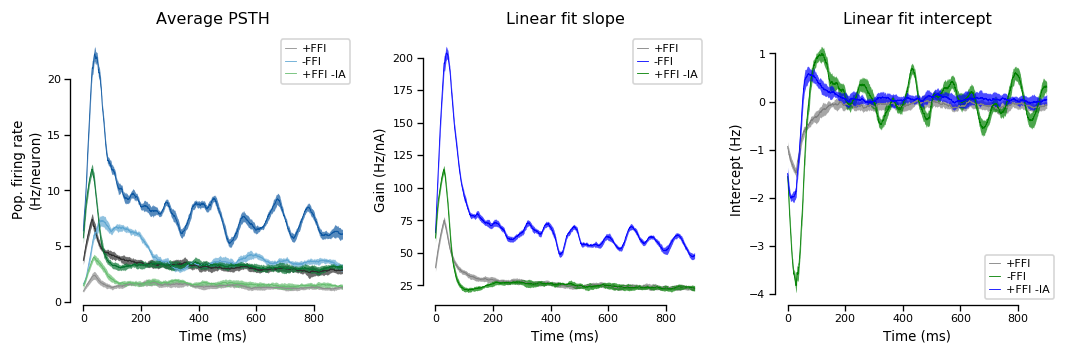

In [22]:
sweeps = [3, 7]

plt.figure(figsize=(9, 3))

plt.subplot(131)
plt.title('Average PSTH')
visualizer.plot_psth('DRN', 'base', 'base', 'Principal PSTH', sweeps, label='+FFI', cmap=plt.get_cmap('Greys'))
visualizer.plot_psth('DRN', 'KO', 'base', 'Principal PSTH', sweeps, label='-FFI', cmap=plt.get_cmap('Blues'))
visualizer.plot_psth('DRN', 'base', 'noIA', 'Principal PSTH', sweeps, label='+FFI -IA', cmap=plt.get_cmap('Greens'))
plt.xlabel('Time (ms)')
plt.ylabel('Pop. firing rate\n(Hz/neuron)')
plt.legend()

plt.subplot(132)
plt.title('Linear fit slope')
visualizer.plot_gain('DRN', 'base', 'base', 'Principal PSTH', color='gray', label='+FFI')
visualizer.plot_gain('DRN', 'KO', 'base', 'Principal PSTH', color='blue', label='-FFI')
visualizer.plot_gain('DRN', 'base', 'noIA', 'Principal PSTH', color='green', label='+FFI -IA')
plt.xlabel('Time (ms)')
plt.ylabel('Gain (Hz/nA)')
plt.legend()

plt.subplot(133)
plt.title('Linear fit intercept')
visualizer.plot_intercept('DRN', 'base', 'base', 'Principal PSTH', color='gray', label='+FFI')
visualizer.plot_intercept('DRN', 'KO', 'base', 'Principal PSTH', color='green', label='-FFI')
visualizer.plot_intercept('DRN', 'base', 'noIA', 'Principal PSTH', color='blue', label='+FFI -IA')
plt.xlabel('Time (ms)')
plt.ylabel('Intercept (Hz)')
plt.legend()

sns.despine(trim=True)
plt.tight_layout()

print('Step amplitudes {} (nA) are shown.'.format(step_amplitudes[sweeps]))

Notice that IA has a clear effect on the initial peak when FFI is present.

## Interaction of IA and GABA KO

Step amplitudes [0.05338645 0.1178309 ] (nA) are shown.


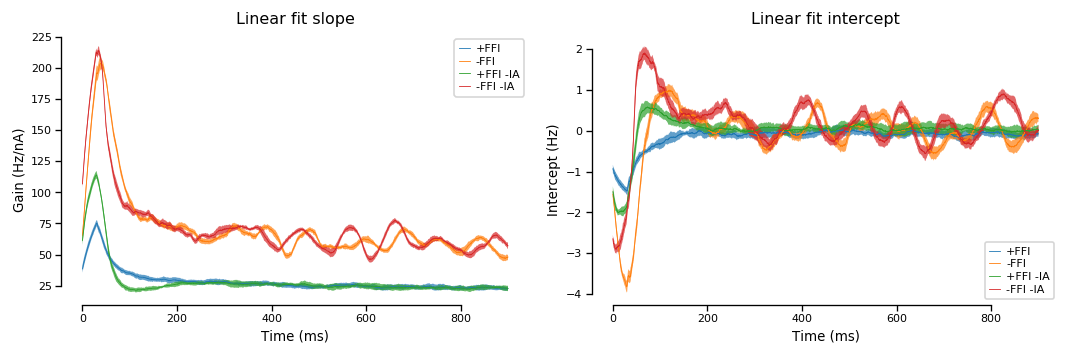

In [23]:
plt.figure(figsize=(9, 3))

plt.subplot(121)
plt.title('Linear fit slope')
visualizer.plot_gain('DRN', 'base', 'base', 'Principal PSTH', label='+FFI')
visualizer.plot_gain('DRN', 'KO', 'base', 'Principal PSTH', label='-FFI')
visualizer.plot_gain('DRN', 'base', 'noIA', 'Principal PSTH', label='+FFI -IA')
visualizer.plot_gain('DRN', 'KO', 'noIA', 'Principal PSTH', label='-FFI -IA')
plt.xlabel('Time (ms)')
plt.ylabel('Gain (Hz/nA)')
plt.legend()

plt.subplot(122)
plt.title('Linear fit intercept')
visualizer.plot_intercept('DRN', 'base', 'base', 'Principal PSTH', label='+FFI')
visualizer.plot_intercept('DRN', 'KO', 'base', 'Principal PSTH', label='-FFI')
visualizer.plot_intercept('DRN', 'base', 'noIA', 'Principal PSTH', label='+FFI -IA')
visualizer.plot_intercept('DRN', 'KO', 'noIA', 'Principal PSTH', label='-FFI -IA')
plt.xlabel('Time (ms)')
plt.ylabel('Intercept (Hz)')
plt.legend()

sns.despine(trim=True)
plt.tight_layout()

print('Step amplitudes {} (nA) are shown.'.format(step_amplitudes[sweeps]))

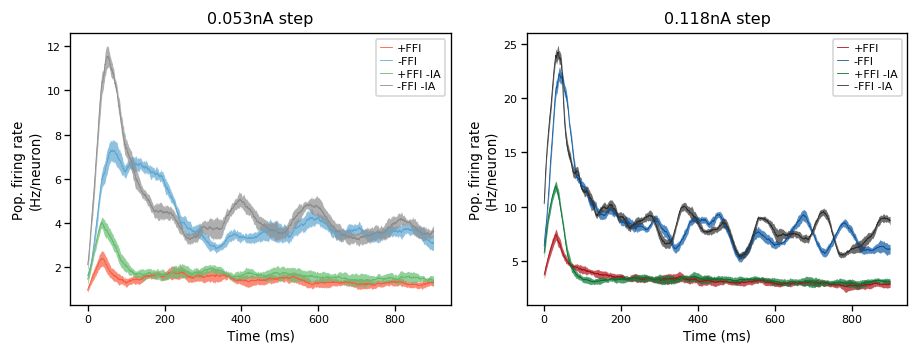

In [24]:
weak_sweep = [3]
strong_sweep = [7]

plt.figure(figsize=(9, 3))

plt.subplot(121)
plt.title('{:.3f}nA step'.format(step_amplitudes[weak_sweep[0]]))
visualizer.plot_psth('DRN', 'base', 'base', 'Principal PSTH', weak_sweep, label='+FFI', cmap=plt.get_cmap('Reds'))
visualizer.plot_psth('DRN', 'KO', 'base', 'Principal PSTH', weak_sweep, label='-FFI', cmap=plt.get_cmap('Blues'))
visualizer.plot_psth('DRN', 'base', 'noIA', 'Principal PSTH', weak_sweep, label='+FFI -IA', cmap=plt.get_cmap('Greens'))
visualizer.plot_psth('DRN', 'KO', 'noIA', 'Principal PSTH', weak_sweep, label='-FFI -IA', cmap=plt.get_cmap('Greys'))
plt.xlabel('Time (ms)')
plt.ylabel('Pop. firing rate\n(Hz/neuron)')
plt.legend()

plt.subplot(122)
plt.title('{:.3f}nA step'.format(step_amplitudes[strong_sweep[0]]))
visualizer.plot_psth('DRN', 'base', 'base', 'Principal PSTH', strong_sweep, label='+FFI', cmap=plt.get_cmap('Reds'))
visualizer.plot_psth('DRN', 'KO', 'base', 'Principal PSTH', strong_sweep, label='-FFI', cmap=plt.get_cmap('Blues'))
visualizer.plot_psth('DRN', 'base', 'noIA', 'Principal PSTH', strong_sweep, label='+FFI -IA', cmap=plt.get_cmap('Greens'))
visualizer.plot_psth('DRN', 'KO', 'noIA', 'Principal PSTH', strong_sweep, label='-FFI -IA', cmap=plt.get_cmap('Greys'))
plt.xlabel('Time (ms)')
plt.ylabel('Pop. firing rate\n(Hz/neuron)')
plt.legend()

## Interaction of IA and GABA input severed

Step amplitudes [0.05338645 0.1178309 ] (nA) are shown.


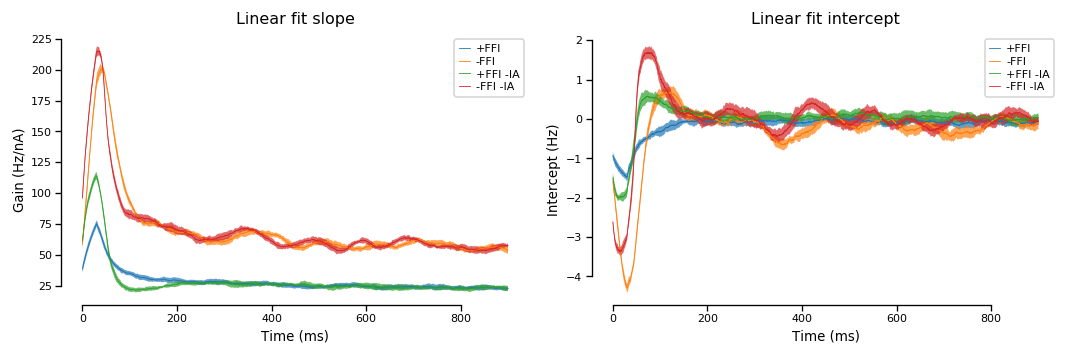

In [25]:
plt.figure(figsize=(9, 3))

plt.subplot(121)
plt.title('Linear fit slope')
visualizer.plot_gain('DRN', 'base', 'base', 'Principal PSTH', label='+FFI')
visualizer.plot_gain('DRN', 'noinput', 'base', 'Principal PSTH', label='-FFI')
visualizer.plot_gain('DRN', 'base', 'noIA', 'Principal PSTH', label='+FFI -IA')
visualizer.plot_gain('DRN', 'noinput', 'noIA', 'Principal PSTH', label='-FFI -IA')
plt.xlabel('Time (ms)')
plt.ylabel('Gain (Hz/nA)')
plt.legend()

plt.subplot(122)
plt.title('Linear fit intercept')
visualizer.plot_intercept('DRN', 'base', 'base', 'Principal PSTH', label='+FFI')
visualizer.plot_intercept('DRN', 'noinput', 'base', 'Principal PSTH', label='-FFI')
visualizer.plot_intercept('DRN', 'base', 'noIA', 'Principal PSTH', label='+FFI -IA')
visualizer.plot_intercept('DRN', 'noinput', 'noIA', 'Principal PSTH', label='-FFI -IA')
plt.xlabel('Time (ms)')
plt.ylabel('Intercept (Hz)')
plt.legend()

sns.despine(trim=True)
plt.tight_layout()

print('Step amplitudes {} (nA) are shown.'.format(step_amplitudes[sweeps]))

Post peak gain is smoothed out when GABA neurons are present but not receiving input. Due to tonic spiking of GABA cells.

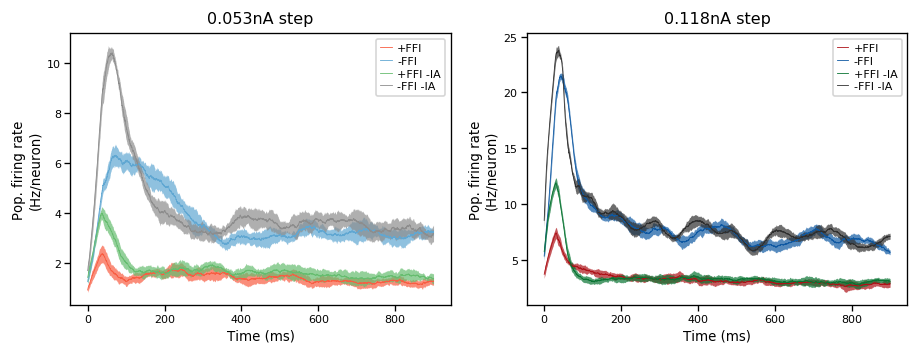

In [26]:
weak_sweep = [3]
strong_sweep = [7]

plt.figure(figsize=(9, 3))

plt.subplot(121)
plt.title('{:.3f}nA step'.format(step_amplitudes[weak_sweep[0]]))
visualizer.plot_psth('DRN', 'base', 'base', 'Principal PSTH', weak_sweep, label='+FFI', cmap=plt.get_cmap('Reds'))
visualizer.plot_psth('DRN', 'noinput', 'base', 'Principal PSTH', weak_sweep, label='-FFI', cmap=plt.get_cmap('Blues'))
visualizer.plot_psth('DRN', 'base', 'noIA', 'Principal PSTH', weak_sweep, label='+FFI -IA', cmap=plt.get_cmap('Greens'))
visualizer.plot_psth('DRN', 'noinput', 'noIA', 'Principal PSTH', weak_sweep, label='-FFI -IA', cmap=plt.get_cmap('Greys'))
plt.xlabel('Time (ms)')
plt.ylabel('Pop. firing rate\n(Hz/neuron)')
plt.legend()

plt.subplot(122)
plt.title('{:.3f}nA step'.format(step_amplitudes[strong_sweep[0]]))
visualizer.plot_psth('DRN', 'base', 'base', 'Principal PSTH', strong_sweep, label='+FFI', cmap=plt.get_cmap('Reds'))
visualizer.plot_psth('DRN', 'noinput', 'base', 'Principal PSTH', strong_sweep, label='-FFI', cmap=plt.get_cmap('Blues'))
visualizer.plot_psth('DRN', 'base', 'noIA', 'Principal PSTH', strong_sweep, label='+FFI -IA', cmap=plt.get_cmap('Greens'))
visualizer.plot_psth('DRN', 'noinput', 'noIA', 'Principal PSTH', strong_sweep, label='-FFI -IA', cmap=plt.get_cmap('Greys'))
plt.xlabel('Time (ms)')
plt.ylabel('Pop. firing rate\n(Hz/neuron)')
plt.legend()

# Effect of AHP truncation

Step amplitudes [0.05338645 0.1178309 ] (nA) are shown.


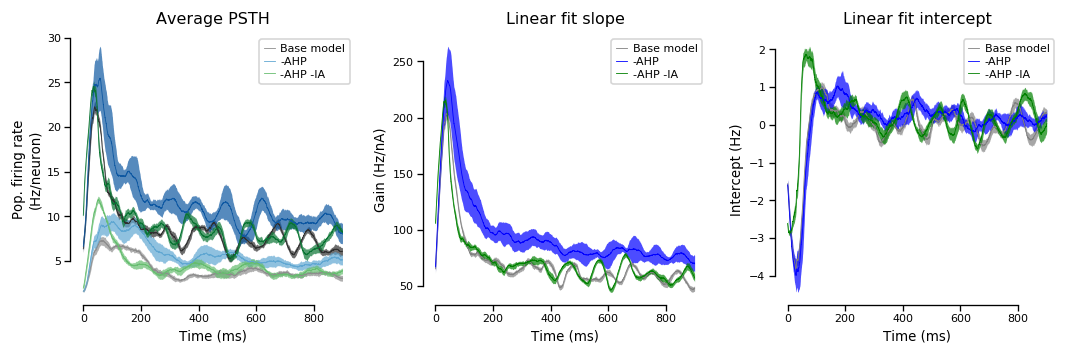

In [27]:
sweeps = [3, 7]

plt.figure(figsize=(9, 3))

plt.subplot(131)
plt.title('Average PSTH')
visualizer.plot_psth('DRN', 'KO', 'base', 'Principal PSTH', sweeps, label='Base model', cmap=plt.get_cmap('Greys'))
visualizer.plot_psth('DRN', 'KO', 'truncatedAHP', 'Principal PSTH', sweeps, label='-AHP', cmap=plt.get_cmap('Blues'))
visualizer.plot_psth('DRN', 'KO', 'truncatedAHP_noIA', 'Principal PSTH', sweeps, label='-AHP -IA', cmap=plt.get_cmap('Greens'))
plt.xlabel('Time (ms)')
plt.ylabel('Pop. firing rate\n(Hz/neuron)')
plt.legend()

plt.subplot(132)
plt.title('Linear fit slope')
visualizer.plot_gain('DRN', 'KO', 'base', 'Principal PSTH', color='gray', label='Base model')
visualizer.plot_gain('DRN', 'KO', 'truncatedAHP', 'Principal PSTH', color='blue', label='-AHP')
visualizer.plot_gain('DRN', 'KO', 'truncatedAHP_noIA', 'Principal PSTH', color='green', label='-AHP -IA')
plt.xlabel('Time (ms)')
plt.ylabel('Gain (Hz/nA)')
plt.legend()

plt.subplot(133)
plt.title('Linear fit intercept')
visualizer.plot_intercept('DRN', 'KO', 'base', 'Principal PSTH', color='gray', label='Base model')
visualizer.plot_intercept('DRN', 'KO', 'truncatedAHP', 'Principal PSTH', color='blue', label='-AHP')
visualizer.plot_intercept('DRN', 'KO', 'truncatedAHP_noIA', 'Principal PSTH', color='green', label='-AHP -IA')
plt.xlabel('Time (ms)')
plt.ylabel('Intercept (Hz)')
plt.legend()

sns.despine(trim=True)
plt.tight_layout()

print('Step amplitudes {} (nA) are shown.'.format(step_amplitudes[sweeps]))

Step amplitudes [0.05338645 0.1178309 ] (nA) are shown.


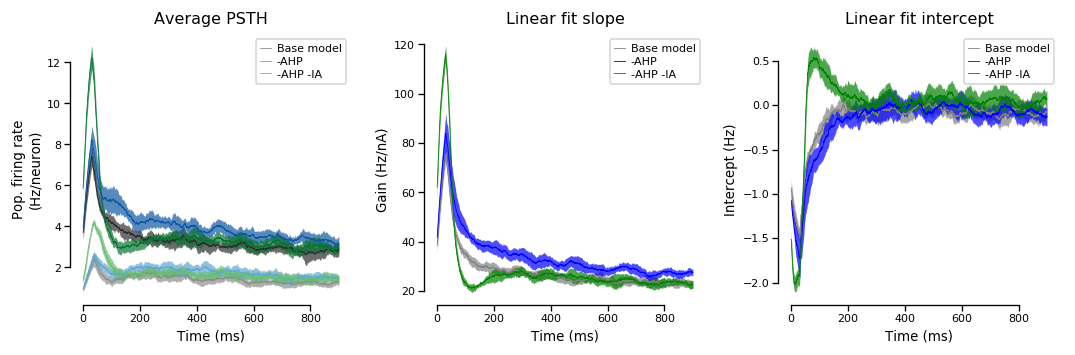

In [28]:
sweeps = [3, 7]

plt.figure(figsize=(9, 3))

plt.subplot(131)
plt.title('Average PSTH')
visualizer.plot_psth('DRN', 'base', 'base', 'Principal PSTH', sweeps, label='Base model', cmap=plt.get_cmap('Greys'))
visualizer.plot_psth('DRN', 'base', 'truncatedAHP', 'Principal PSTH', sweeps, label='-AHP', cmap=plt.get_cmap('Blues'))
visualizer.plot_psth('DRN', 'base', 'truncatedAHP_noIA', 'Principal PSTH', sweeps, label='-AHP -IA', cmap=plt.get_cmap('Greens'))
plt.xlabel('Time (ms)')
plt.ylabel('Pop. firing rate\n(Hz/neuron)')
plt.legend()

plt.subplot(132)
plt.title('Linear fit slope')
visualizer.plot_gain('DRN', 'base', 'base', 'Principal PSTH', color='gray', label='Base model')
visualizer.plot_gain('DRN', 'base', 'truncatedAHP', 'Principal PSTH', color='blue', label='-AHP')
visualizer.plot_gain('DRN', 'base', 'truncatedAHP_noIA', 'Principal PSTH', color='green', label='-AHP -IA')
plt.xlabel('Time (ms)')
plt.ylabel('Gain (Hz/nA)')
plt.legend()

plt.subplot(133)
plt.title('Linear fit intercept')
visualizer.plot_intercept('DRN', 'base', 'base', 'Principal PSTH', color='gray', label='Base model')
visualizer.plot_intercept('DRN', 'base', 'truncatedAHP', 'Principal PSTH', color='blue', label='-AHP')
visualizer.plot_intercept('DRN', 'base', 'truncatedAHP_noIA', 'Principal PSTH', color='green', label='-AHP -IA')
plt.xlabel('Time (ms)')
plt.ylabel('Intercept (Hz)')
plt.legend()

sns.despine(trim=True)
plt.tight_layout()

print('Step amplitudes {} (nA) are shown.'.format(step_amplitudes[sweeps]))

Step amplitudes [0.05338645 0.1178309 ] (nA) are shown.


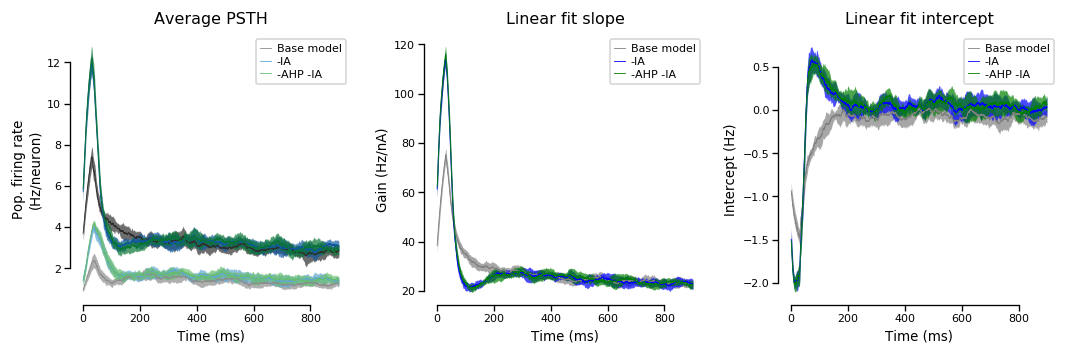

In [29]:
sweeps = [3, 7]

plt.figure(figsize=(9, 3))

plt.subplot(131)
plt.title('Average PSTH')
visualizer.plot_psth('DRN', 'base', 'base', 'Principal PSTH', sweeps, label='Base model', cmap=plt.get_cmap('Greys'))
visualizer.plot_psth('DRN', 'base', 'noIA', 'Principal PSTH', sweeps, label='-IA', cmap=plt.get_cmap('Blues'))
visualizer.plot_psth('DRN', 'base', 'truncatedAHP_noIA', 'Principal PSTH', sweeps, label='-AHP -IA', cmap=plt.get_cmap('Greens'))
plt.xlabel('Time (ms)')
plt.ylabel('Pop. firing rate\n(Hz/neuron)')
plt.legend()

plt.subplot(132)
plt.title('Linear fit slope')
visualizer.plot_gain('DRN', 'base', 'base', 'Principal PSTH', color='gray', label='Base model')
visualizer.plot_gain('DRN', 'base', 'noIA', 'Principal PSTH', color='blue', label='-IA')
visualizer.plot_gain('DRN', 'base', 'truncatedAHP_noIA', 'Principal PSTH', color='green', label='-AHP -IA')
plt.xlabel('Time (ms)')
plt.ylabel('Gain (Hz/nA)')
plt.legend()

plt.subplot(133)
plt.title('Linear fit intercept')
visualizer.plot_intercept('DRN', 'base', 'base', 'Principal PSTH', color='gray', label='Base model')
visualizer.plot_intercept('DRN', 'base', 'noIA', 'Principal PSTH', color='blue', label='-IA')
visualizer.plot_intercept('DRN', 'base', 'truncatedAHP_noIA', 'Principal PSTH', color='green', label='-AHP -IA')
plt.xlabel('Time (ms)')
plt.ylabel('Intercept (Hz)')
plt.legend()

sns.despine(trim=True)
plt.tight_layout()

print('Step amplitudes {} (nA) are shown.'.format(step_amplitudes[sweeps]))

Step amplitudes [0.05338645 0.1178309 ] (nA) are shown.


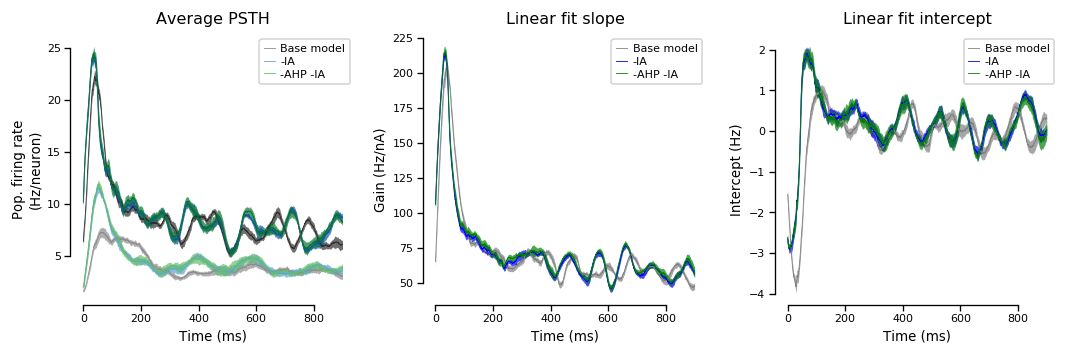

In [30]:
sweeps = [3, 7]

plt.figure(figsize=(9, 3))

plt.subplot(131)
plt.title('Average PSTH')
visualizer.plot_psth('DRN', 'KO', 'base', 'Principal PSTH', sweeps, label='Base model', cmap=plt.get_cmap('Greys'))
visualizer.plot_psth('DRN', 'KO', 'noIA', 'Principal PSTH', sweeps, label='-IA', cmap=plt.get_cmap('Blues'))
visualizer.plot_psth('DRN', 'KO', 'truncatedAHP_noIA', 'Principal PSTH', sweeps, label='-AHP -IA', cmap=plt.get_cmap('Greens'))
plt.xlabel('Time (ms)')
plt.ylabel('Pop. firing rate\n(Hz/neuron)')
plt.legend()

plt.subplot(132)
plt.title('Linear fit slope')
visualizer.plot_gain('DRN', 'KO', 'base', 'Principal PSTH', color='gray', label='Base model')
visualizer.plot_gain('DRN', 'KO', 'noIA', 'Principal PSTH', color='blue', label='-IA')
visualizer.plot_gain('DRN', 'KO', 'truncatedAHP_noIA', 'Principal PSTH', color='green', label='-AHP -IA')
plt.xlabel('Time (ms)')
plt.ylabel('Gain (Hz/nA)')
plt.legend()

plt.subplot(133)
plt.title('Linear fit intercept')
visualizer.plot_intercept('DRN', 'KO', 'base', 'Principal PSTH', color='gray', label='Base model')
visualizer.plot_intercept('DRN', 'KO', 'noIA', 'Principal PSTH', color='blue', label='-IA')
visualizer.plot_intercept('DRN', 'KO', 'truncatedAHP_noIA', 'Principal PSTH', color='green', label='-AHP -IA')
plt.xlabel('Time (ms)')
plt.ylabel('Intercept (Hz)')
plt.legend()

sns.despine(trim=True)
plt.tight_layout()

print('Step amplitudes {} (nA) are shown.'.format(step_amplitudes[sweeps]))

# Inspect PFC

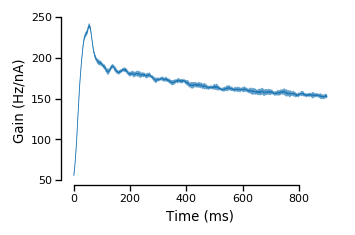

In [31]:
plt.subplot(111)
visualizer.plot_gain('mPFC', 'KO', 'base', 'Principal PSTH')
plt.xlabel('Time (ms)')
plt.ylabel('Gain (Hz/nA)')

sns.despine(trim=True)
plt.tight_layout()

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'mpfc_gain_illustration.png'))

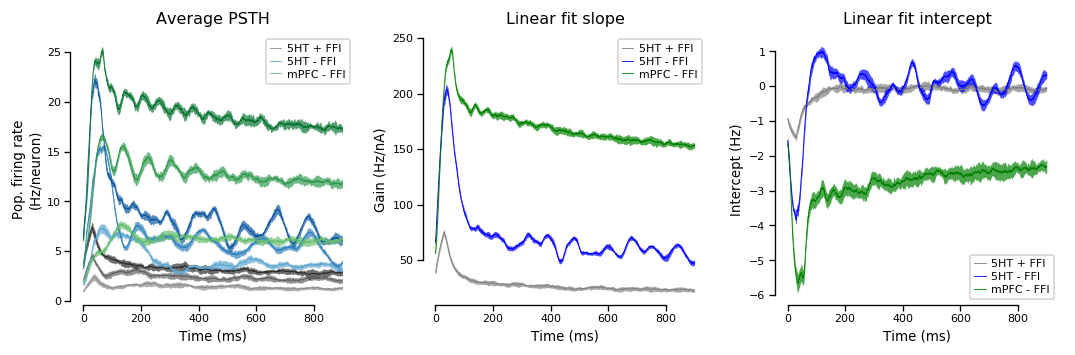

In [32]:
sweeps = [3, 5, 7]

plt.figure(figsize=(9, 3))

plt.subplot(131)
plt.title('Average PSTH')
visualizer.plot_psth('DRN', 'base', 'base', 'Principal PSTH', sweeps, label='5HT + FFI', cmap=plt.get_cmap('Greys'))
visualizer.plot_psth('DRN', 'KO', 'base', 'Principal PSTH', sweeps, label='5HT - FFI', cmap=plt.get_cmap('Blues'))
visualizer.plot_psth('mPFC', 'KO', 'base', 'Principal PSTH', sweeps, label='mPFC - FFI', cmap=plt.get_cmap('Greens'))
plt.xlabel('Time (ms)')
plt.ylabel('Pop. firing rate\n(Hz/neuron)')
plt.legend()

plt.subplot(132)
plt.title('Linear fit slope')
visualizer.plot_gain('DRN', 'base', 'base', 'Principal PSTH', label='5HT + FFI', color='gray')
visualizer.plot_gain('DRN', 'KO', 'base', 'Principal PSTH', label='5HT - FFI', color='blue')
visualizer.plot_gain('mPFC', 'KO', 'base', 'Principal PSTH', label='mPFC - FFI', color='green')
plt.xlabel('Time (ms)')
plt.ylabel('Gain (Hz/nA)')
plt.legend()

plt.subplot(133)
plt.title('Linear fit intercept')
visualizer.plot_intercept('DRN', 'base', 'base', 'Principal PSTH', label='5HT + FFI', color='gray')
visualizer.plot_intercept('DRN', 'KO', 'base', 'Principal PSTH', label='5HT - FFI', color='blue')
visualizer.plot_intercept('mPFC', 'KO', 'base', 'Principal PSTH', label='mPFC - FFI', color='green')
plt.xlabel('Time (ms)')
plt.ylabel('Intercept (Hz)')
plt.legend()

sns.despine(trim=True)
plt.tight_layout()

#print('Step amplitudes {} (nA) are shown.'.format(step_amplitudes[sweeps]))

In [33]:
mpfc_psth = select_PSTH_dataset(psth_df, 'mPFC', 'KO', 'base', 'Principal PSTH')

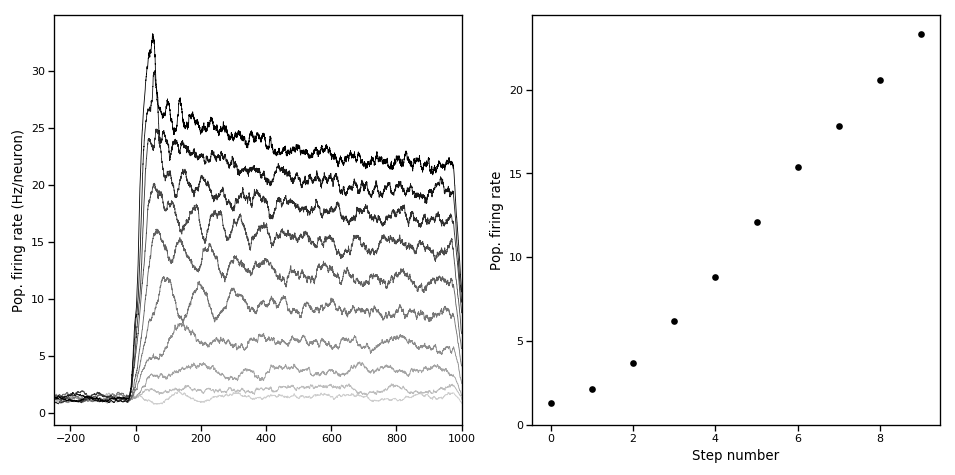

In [34]:
plt.figure(figsize=(8, 4))

plt.subplot(121)
plot_lines_cmap(t_vec, mpfc_psth[0, ::1, :].T, cmap, start=0.3)
plt.xlim(-250, 1000)
plt.ylabel('Pop. firing rate (Hz/neuron)')

plt.subplot(122)
plt.plot(mpfc_psth[0, :, 15000], 'k.')
plt.ylim(0, plt.ylim()[1])
plt.ylabel('Pop. firing rate')
plt.xlabel('Step number')

plt.tight_layout()

plt.show()

Text(0,0.5,'Pop. firing rate (Hz/neuron)')

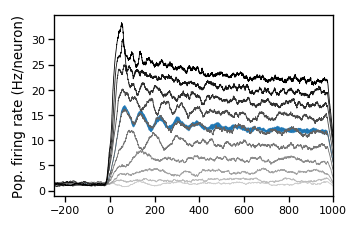

In [35]:
sweep_no = 5

plt.subplot(111)
plt.fill_between(t_vec, mpfc_psth[:, sweep_no, :].mean(axis=0) - mpfc_psth[:, sweep_no, :].std(axis=0), mpfc_psth[:, sweep_no, :].mean(axis=0) + mpfc_psth[:, sweep_no, :].std(axis=0))
plot_lines_cmap(t_vec, mpfc_psth[0, ::1, :].T, cmap, start=0.3)
plt.xlim(-250, 1000)
plt.ylabel('Pop. firing rate (Hz/neuron)')

# Inspect SOM

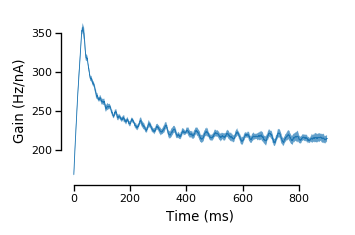

In [36]:
plt.subplot(111)
visualizer.plot_gain('DRN', 'base', 'base', 'GABA PSTH')
plt.xlabel('Time (ms)')
plt.ylabel('Gain (Hz/nA)')

sns.despine(trim=True)
plt.tight_layout()

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'som_neuron_gain_illustration.png'))

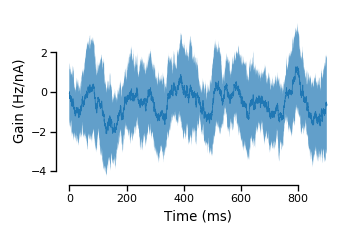

In [37]:
plt.subplot(111)
visualizer.plot_gain('DRN', 'noinput', 'base', 'GABA PSTH')
plt.xlabel('Time (ms)')
plt.ylabel('Gain (Hz/nA)')

sns.despine(trim=True)
plt.tight_layout()

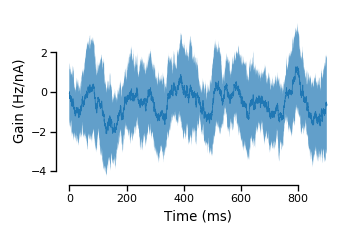

In [38]:
plt.subplot(111)
visualizer.plot_gain('DRN', 'noinput', 'base', 'GABA PSTH')
plt.xlabel('Time (ms)')
plt.ylabel('Gain (Hz/nA)')

sns.despine(trim=True)
plt.tight_layout()

Negative control. If I did my simulations right, GABA in the `noinput` condition should be flat.

# Compare cell types

In [37]:
def get_gain_ratio(gain_estimator):
    peak_gain = gain_estimator.gain.max()
    steady_state_gain = gain_estimator.gain[-1000:].mean()
    return peak_gain / steady_state_gain

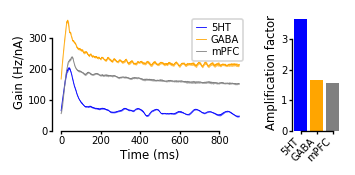

In [56]:
plt.figure(figsize=(3, 1.5))

ratio_spec = gs.GridSpec(1, 2, width_ratios=[1, 0.25])

plt.subplot(ratio_spec[:, 0])
visualizer.plot_gain('DRN', 'KO', 'base', 'Principal PSTH', label='5HT', color='blue')
visualizer.plot_gain('DRN', 'base', 'base', 'GABA PSTH', label='GABA', color='orange')
visualizer.plot_gain('mPFC', 'KO', 'base', 'Principal PSTH', label='mPFC', color='gray')
plt.ylim(0, plt.ylim()[1])
plt.xlabel('Time (ms)')
plt.ylabel('Gain (Hz/nA)')
plt.legend()

plt.subplot(ratio_spec[:, 1])
plt.bar(x=0, height=get_gain_ratio(visualizer._fit_gain_estimator('DRN', 'KO', 'base', 'Principal PSTH')), color='blue')
plt.bar(x=1, height=get_gain_ratio(visualizer._fit_gain_estimator('DRN', 'base', 'base', 'GABA PSTH')), color='orange')
plt.bar(x=2, height=get_gain_ratio(visualizer._fit_gain_estimator('mPFC', 'KO', 'base', 'Principal PSTH')), color='gray')
plt.ylabel('Amplification factor')
plt.xticks([0, 1, 2], ['5HT', 'GABA', 'mPFC'], rotation=45, ha='right')

sns.despine(trim=True)

plt.tight_layout()

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'celltype_peak_comparison.png'))

In [57]:
get_gain_ratio(visualizer._fit_gain_estimator('DRN', 'base', 'base', 'Principal PSTH'))

3.234055982117581

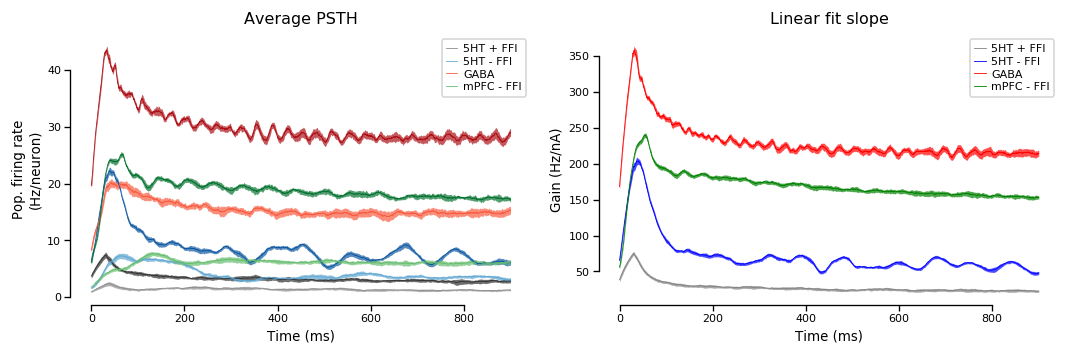

In [39]:
sweeps = [3, 7]

plt.figure(figsize=(9, 3))

plt.subplot(121)
plt.title('Average PSTH')
visualizer.plot_psth('DRN', 'base', 'base', 'Principal PSTH', sweeps, label='5HT + FFI', cmap=plt.get_cmap('Greys'))
visualizer.plot_psth('DRN', 'KO', 'base', 'Principal PSTH', sweeps, label='5HT - FFI', cmap=plt.get_cmap('Blues'))
visualizer.plot_psth('DRN', 'base', 'base', 'GABA PSTH', sweeps, label='GABA', cmap=plt.get_cmap('Reds'))
visualizer.plot_psth('mPFC', 'KO', 'base', 'Principal PSTH', sweeps, label='mPFC - FFI', cmap=plt.get_cmap('Greens'))
plt.xlabel('Time (ms)')
plt.ylabel('Pop. firing rate\n(Hz/neuron)')
plt.legend()

plt.subplot(122)
plt.title('Linear fit slope')
visualizer.plot_gain('DRN', 'base', 'base', 'Principal PSTH', label='5HT + FFI', color='gray')
visualizer.plot_gain('DRN', 'KO', 'base', 'Principal PSTH', label='5HT - FFI', color='blue')
visualizer.plot_gain('DRN', 'base', 'base', 'GABA PSTH', label='GABA', color='red')
visualizer.plot_gain('mPFC', 'KO', 'base', 'Principal PSTH', label='mPFC - FFI', color='green')
plt.xlabel('Time (ms)')
plt.ylabel('Gain (Hz/nA)')
plt.legend()

sns.despine(trim=True)
plt.tight_layout()

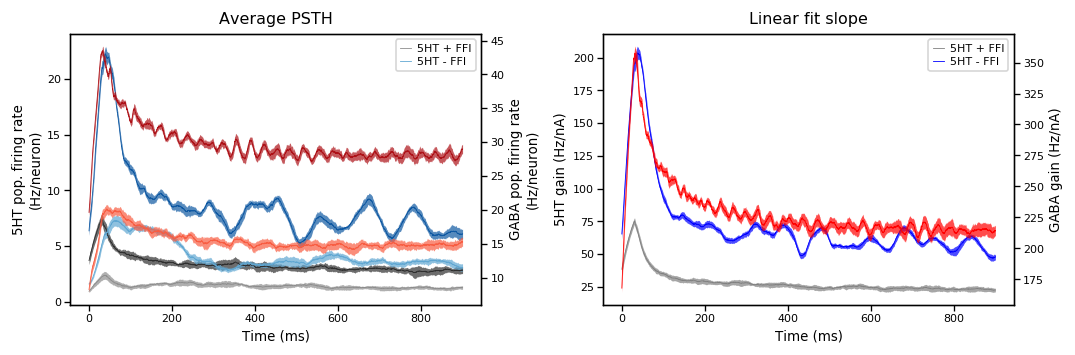

In [40]:
sweeps = [3, 7]

plt.figure(figsize=(9, 3))

psth_ax = plt.subplot(121)
plt.title('Average PSTH')
visualizer.plot_psth('DRN', 'base', 'base', 'Principal PSTH', sweeps, label='5HT + FFI', cmap=plt.get_cmap('Greys'))
visualizer.plot_psth('DRN', 'KO', 'base', 'Principal PSTH', sweeps, label='5HT - FFI', cmap=plt.get_cmap('Blues'))
psth_ax.legend()
psth_ax.set_ylabel('5HT pop. firing rate\n(Hz/neuron)')
psth_ax.set_xlabel('Time (ms)')

psth_twin_ax = psth_ax.twinx()
visualizer.plot_psth('DRN', 'base', 'base', 'GABA PSTH', sweeps, label='GABA', cmap=plt.get_cmap('Reds'))
psth_twin_ax.set_ylabel('GABA pop. firing rate\n(Hz/neuron)')

gain_ax = plt.subplot(122)
plt.title('Linear fit slope')
visualizer.plot_gain('DRN', 'base', 'base', 'Principal PSTH', label='5HT + FFI', color='gray')
visualizer.plot_gain('DRN', 'KO', 'base', 'Principal PSTH', label='5HT - FFI', color='blue')
plt.xlabel('Time (ms)')
plt.ylabel('5HT gain (Hz/nA)')
gain_ax.legend()

gain_twin_ax = gain_ax.twinx()
visualizer.plot_gain('DRN', 'base', 'base', 'GABA PSTH', label='GABA', color='red')
gain_twin_ax.set_ylabel('GABA gain (Hz/nA)')

#sns.despine(trim=True)
plt.tight_layout()

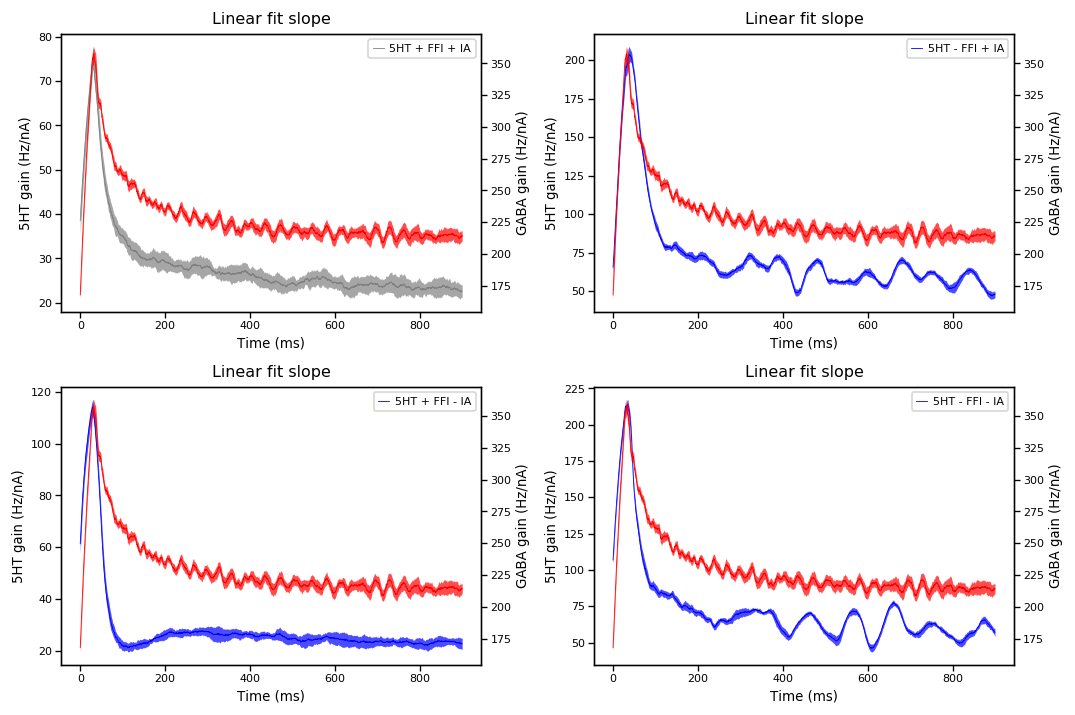

In [41]:
plt.figure(figsize=(9, 6))

gain_ax = plt.subplot(221)
plt.title('Linear fit slope')
visualizer.plot_gain('DRN', 'base', 'base', 'Principal PSTH', label='5HT + FFI + IA', color='gray')
plt.xlabel('Time (ms)')
plt.ylabel('5HT gain (Hz/nA)')
gain_ax.legend()

gain_twin_ax = gain_ax.twinx()
visualizer.plot_gain('DRN', 'base', 'base', 'GABA PSTH', label='GABA', color='red')
gain_twin_ax.set_ylabel('GABA gain (Hz/nA)')

gain_ax = plt.subplot(222)
plt.title('Linear fit slope')
visualizer.plot_gain('DRN', 'KO', 'base', 'Principal PSTH', label='5HT - FFI + IA', color='blue')
plt.xlabel('Time (ms)')
plt.ylabel('5HT gain (Hz/nA)')
gain_ax.legend()

gain_twin_ax = gain_ax.twinx()
visualizer.plot_gain('DRN', 'base', 'base', 'GABA PSTH', label='GABA', color='red')
gain_twin_ax.set_ylabel('GABA gain (Hz/nA)')

gain_ax = plt.subplot(223)
plt.title('Linear fit slope')
visualizer.plot_gain('DRN', 'base', 'noIA', 'Principal PSTH', label='5HT + FFI - IA', color='blue')
plt.xlabel('Time (ms)')
plt.ylabel('5HT gain (Hz/nA)')
gain_ax.legend()

gain_twin_ax = gain_ax.twinx()
visualizer.plot_gain('DRN', 'base', 'base', 'GABA PSTH', label='GABA', color='red')
gain_twin_ax.set_ylabel('GABA gain (Hz/nA)')

gain_ax = plt.subplot(224)
plt.title('Linear fit slope')
visualizer.plot_gain('DRN', 'KO', 'noIA', 'Principal PSTH', label='5HT - FFI - IA', color='blue')
plt.xlabel('Time (ms)')
plt.ylabel('5HT gain (Hz/nA)')
gain_ax.legend()

gain_twin_ax = gain_ax.twinx()
visualizer.plot_gain('DRN', 'base', 'base', 'GABA PSTH', label='GABA', color='red')
gain_twin_ax.set_ylabel('GABA gain (Hz/nA)')

plt.tight_layout()